In [1]:
from siuba import *
from plotnine import *
from calitp.tables import tbl
from siuba.sql import LazyTbl
from siuba.experimental import completer

# for all the feeds we consume, how many publish the following fields:

# How many feeds publish stops.tts_stop_name?


In [2]:
tbl_feed_info = (tbl.gtfs_schedule.feed_info())

In [3]:
tbl_stops = (tbl.gtfs_schedule.stops())

In [4]:
tbl_feed_stops = (
    tbl_stops
    >>left_join (
        _,  tbl_feed_info, ["calitp_itp_id", "calitp_url_number"],
    )
    >> inner_join(_, tbl.views.gtfs_agency_names(), ["calitp_itp_id", "calitp_url_number"])
)

In [5]:
(tbl_feed_stops
  >> group_by(_.calitp_itp_id, _.calitp_url_number, _.agency_name)
  >> summarize(n_filled_entries = _.tts_stop_name.notna().astype(int).sum())
  >> count(_.n_filled_entries)
)

,n_filled_entries,n
0,0,189


# How many feeds publish stops.tts_stop_name? `none`

# How many Stops publish wheelchair_boarding?

##For parentless stops:
0 or empty - No accessibility information for the stop.
1 - Some vehicles at this stop can be boarded by a rider in a wheelchair.
2 - Wheelchair boarding is not possible at this stop.

For child stops:
0 or empty - Stop will inherit its wheelchair_boarding behavior from the parent station, if specified in the parent.
1 - There exists some accessible path from outside the station to the specific stop/platform.
2 - There exists no accessible path from outside the station to the specific stop/platform.

For station entrances/exits:
0 or empty - Station entrance will inherit its wheelchair_boarding behavior from the parent station, if specified for the parent.
1 - Station entrance is wheelchair accessible.
2 - No accessible path from station entrance to stops/platforms.


In [6]:
wheelchair_boarding = tbl_feed_stops >> select(_.wheelchair_boarding) >> collect()

In [7]:
tbl_wheelchair_boarding = (
    tbl_feed_stops 
        >> count(_.calitp_itp_id, _.calitp_url_number, _.wheelchair_boarding) 
        >> count(_.wheelchair_boarding)
)
#n is number of feeds where WC value of 0

In [8]:
tbl_wheelchair_boarding

,wheelchair_boarding,n
0,0,141
1,None,43
2,1,43
3,2,9


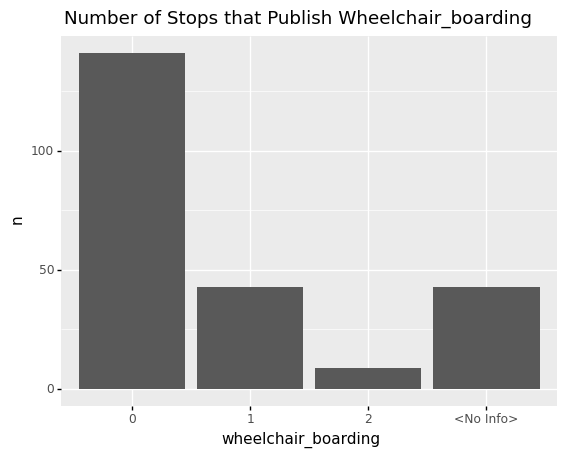

<ggplot: (8761372581798)>

In [9]:
from siuba.dply.forcats import fct_lump
(
    tbl_wheelchair_boarding
    >> collect()
    >> mutate(wheelchair_boarding = fct_lump(_.wheelchair_boarding.fillna("<No Info>"), n = 4, w = _.n))    
    >> ggplot(aes("wheelchair_boarding", "n"))
    + geom_col()
    + ggtitle("Number of Stops that Publish Wheelchair_boarding ")
)


# How many trips publish wheelchair_accessibility?

In [10]:
tbl_wheelchair_trips = (
    tbl.gtfs_schedule.trips()
)

In [11]:
tbl_feed_trips = (
    tbl_wheelchair_trips
    >> left_join (
            _,  tbl_feed_info, ["calitp_itp_id", "calitp_url_number"],
    )
    >> inner_join(_, tbl.views.gtfs_agency_names(), ["calitp_itp_id", "calitp_url_number"])
)

In [12]:
feed_trip_counts = (
    tbl_feed_trips
    >> count(_.calitp_itp_id, _.calitp_url_number, _.agency_name, _.wheelchair_accessible
        )
    >> count(_.wheelchair_accessible)
)

In [13]:
feed_trip_counts

,wheelchair_accessible,n
0,None,157
1,1,20
2,0,14
3,2,2


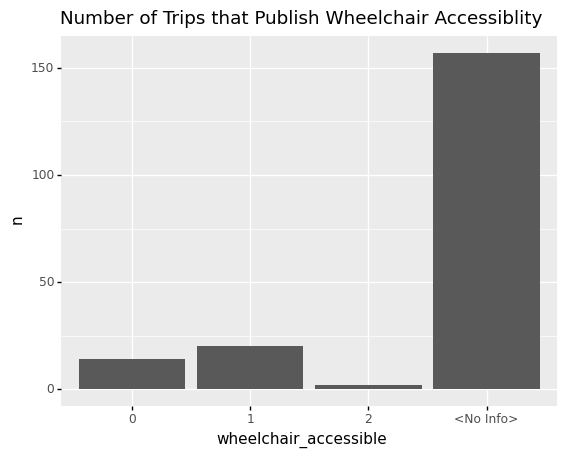

<ggplot: (8761351838778)>

In [14]:
(
    feed_trip_counts
    >> collect()
    >> mutate(wheelchair_accessible = fct_lump(_.wheelchair_accessible.fillna("<No Info>"), n = 4, w = _.n))    
    >> ggplot(aes("wheelchair_accessible", "n"))
    + geom_col()
    + ggtitle("Number of Trips that Publish Wheelchair Accessiblity")
)


# Are There trips without wheelchair boarding that have stop wheelchair boarding?

# How many feeds publish specific .txt files?

In [15]:
tbl_file_updates = (tbl.gtfs_schedule_history.calitp_files_updates())

In [16]:
tbl_feed_file_updates = (
    tbl_file_updates
    >> left_join (
            _,  tbl_feed_info, ["calitp_itp_id", "calitp_url_number"],
    )
    >> inner_join(_, tbl.views.gtfs_agency_names(), ["calitp_itp_id", "calitp_url_number"])
)

In [17]:
feed_file_updates = (
    tbl_feed_file_updates
    >> count(_.calitp_itp_id, _.calitp_url_number, _.agency_name, _.name
        )
    >> count(_.name, _.agency_name) 
    >> collect()
)

# How many feeds publish fare_leg_rules.txt? (Fares v.2) 

In [18]:
feed_file_updates >> filter(_.name == "fare_leg_rules.txt")

,name,agency_name,n
426,fare_leg_rules.txt,Rosemead Explorer,1
617,fare_leg_rules.txt,Auburn Transit,1
687,fare_leg_rules.txt,Avalon Transit,1
913,fare_leg_rules.txt,Bell Gardens,1
949,fare_leg_rules.txt,Bellflower Bus,1
951,fare_leg_rules.txt,Santa Barbara Metropolitan Transit District,1
1186,fare_leg_rules.txt,Calaveras Transit,1
1201,fare_leg_rules.txt,Simi Valley Transit,1
1515,fare_leg_rules.txt,Susanville Indian Rancheria Public Transportat...,1
1571,fare_leg_rules.txt,Tahoe Transportation,1


In [19]:
feed_file_updates >> filter(_.name == "fare_leg_rules.txt") >> count(_.name)

,name,n
0,fare_leg_rules.txt,26


# How many feeds publish fare_leg_rules.txt? `26`

# How many feeds publish fare_rules.txt? (Fares v1)

In [20]:
feed_file_updates >> filter(_.name == "fare_rules.txt")

,name,agency_name,n
2,fare_rules.txt,San Francisco Bay Ferry,2
26,fare_rules.txt,SamTrans,2
38,fare_rules.txt,SolTrans,2
95,fare_rules.txt,Fairfield and Suisun Transit,2
120,fare_rules.txt,Porterville Transit,1
...,...,...,...
3839,fare_rules.txt,Pasadena Transit,1
3862,fare_rules.txt,Caltrain,1
3879,fare_rules.txt,Petaluma Transit,1
3918,fare_rules.txt,Placer County Transit,1


# How many feeds publish fare_rules.txt? `152`

# How many feeds publish pathways.txt?

In [21]:
feed_file_updates >> filter(_.name == "pathways.txt")

,name,agency_name,n
3369,pathways.txt,MTC 511,1


# How many feeds publish levels.txt? `1`

# How many feeds publish levels.txt?

In [22]:
feed_file_updates >> filter(_.name == "levels.txt")

,name,agency_name,n
3375,levels.txt,MTC 511,1


# How many feeds publish levels.txt? `1`

# What percentage of feeds have atleast 1 or 2 in their stops.wheelchair or trips.accessibility?

In [23]:
pk_feed = ["calitp_itp_id", "calitp_url_number"]

tbl_feeds_raw = (
    tbl.views.gtfs_agency_names()
    >> left_join(_, tbl.gtfs_schedule.feed_info(), pk_feed)
    >> select(_.calitp_itp_id, _.calitp_url_number, _.agency_name, _.feed_publisher_name)
    >> mutate(feed_publisher_name = _.feed_publisher_name.fillna("Missing Publisher Name"))
    # Remove itp id 200 (MTC-511), since they have many feed_info files
    >> filter(_.calitp_itp_id != 200)
)

tbl_feed_metrics_stops = (
    tbl.gtfs_schedule.stops()
    >> inner_join(_, tbl_feeds_raw, pk_feed)
    >> mutate(
        wheelchair_boarding=_.wheelchair_boarding.fillna("missing"),
        wheelchair_marked=(_.wheelchair_boarding == "1")
        | (_.wheelchair_boarding == "2"),
    )
    >> group_by(*pk_feed)
    >> summarize(prop_stop_wheelchair_marked=_.wheelchair_marked.astype(int).mean())
    >> mutate(has_stop_wheelchair_entry = _.prop_stop_wheelchair_marked > 0)
)

tbl_feed_metrics_trips = (tbl.gtfs_schedule.trips() >> inner_join(_, tbl_feeds_raw, pk_feed)
    >> mutate(
        wheelchair_accessible=_.wheelchair_accessible.fillna("missing"),
        wheelchair_marked=(_.wheelchair_accessible == "1")
        | (_.wheelchair_accessible == "2"),
    )
    >> group_by(*pk_feed)
    >> summarize(prop_trip_wheelchair_marked=_.wheelchair_marked.astype(int).mean())
    >> mutate(has_trip_wheelchair_entry = _.prop_trip_wheelchair_marked > 0)
)

In [24]:
tbl_feed_metrics = (
    tbl_feeds_raw
    >> inner_join(_, tbl_feed_metrics_stops, pk_feed)
    >> inner_join(_, tbl_feed_metrics_trips, pk_feed)
    >> collect()
)

In [25]:
tbl_publisher_counts = (tbl_feed_metrics >> count(_.feed_publisher_name) >> rename(ttl_publisher_feeds = "n"))

### Counting each combination of no trips or stops wheelchair entries

In [26]:
tbl_feed_metrics >> count(_.has_trip_wheelchair_entry, _.has_stop_wheelchair_entry)

,has_trip_wheelchair_entry,has_stop_wheelchair_entry,n
0,False,False,138
1,False,True,30
2,True,False,7
3,True,True,13


### Percentage with a trip or stop wheelchair entry

In [27]:
(
    tbl_feed_metrics
    >> count(
        has_trip_or_stop_entry=_.has_trip_wheelchair_entry | _.has_stop_wheelchair_entry
    )
    >> mutate(prop=_.n / _.n.sum())
)

,has_trip_or_stop_entry,n,prop
0,False,138,0.734043
1,True,50,0.265957


## Vendor lists WITHOUT entries


In [28]:
# There are 32 vendors (although we are counting "missing" as a vendor)
tbl_publisher_counts >> count()

,n
0,32


### Vendors with no stop wheelchair entries

In [29]:
# count
(
    tbl_feed_metrics
    >> filter(~_.has_stop_wheelchair_entry)
    >> count(_.feed_publisher_name, sort=True)
    >> rename(n_no_stop_entry = "n")
    >> left_join(_, tbl_publisher_counts, "feed_publisher_name")
    >> mutate(prop_no_stop_entry = _.n_no_stop_entry / _.ttl_publisher_feeds)
)

,feed_publisher_name,n_no_stop_entry,ttl_publisher_feeds,prop_no_stop_entry
0,"Trillium Solutions, Inc.",84,113,0.743363
1,Missing Publisher Name,25,27,0.925926
2,511 SF Bay,9,12,0.750000
3,GMV Syncromatics,5,5,1.000000
4,Los Angeles County Metropolitan Transportation...,2,2,1.000000
5,Big Blue Bus,1,1,1.000000
6,Optibus,1,1,1.000000
7,Unitrans,1,1,1.000000
8,Bay Area Rapid Transit,1,1,1.000000
9,Transnnovation Inc,1,1,1.000000


### Vendors with no trip wheelchair entries

In [30]:
(
    tbl_feed_metrics
    >> filter(~_.has_trip_wheelchair_entry)
    >> count(_.feed_publisher_name, sort=True)
    >> rename(n_no_trip_entry = "n")
    >> left_join(_, tbl_publisher_counts, "feed_publisher_name")
    >> mutate(prop_no_trip_entry = _.n_no_trip_entry / _.ttl_publisher_feeds)
)

,feed_publisher_name,n_no_trip_entry,ttl_publisher_feeds,prop_no_trip_entry
0,"Trillium Solutions, Inc.",111,113,0.982301
1,Missing Publisher Name,24,27,0.888889
2,511 SF Bay,9,12,0.750000
3,GMV Syncromatics,5,5,1.000000
4,Los Angeles County Metropolitan Transportation...,2,2,1.000000
5,Optibus,1,1,1.000000
6,Transnnovation Inc,1,1,1.000000
7,Santa Clara Valley Transportation Authority,1,1,1.000000
8,San Joaquin Regional Transit District (RTD),1,1,1.000000
9,Sacramento Regional Transit,1,1,1.000000


## Vendor lists WITH entries

### Vendors with stop wheelchair entries

In [31]:
# count
(
    tbl_feed_metrics
    >> filter(_.has_stop_wheelchair_entry)
    >> count(_.feed_publisher_name, sort=True)
    >> rename(n_stop_entry = "n")
    >> left_join(_, tbl_publisher_counts, "feed_publisher_name")
    >> mutate(prop_stop_entry = _.n_stop_entry / _.ttl_publisher_feeds)
)

,feed_publisher_name,n_stop_entry,ttl_publisher_feeds,prop_stop_entry
0,"Trillium Solutions, Inc.",29,113,0.256637
1,511 SF Bay,3,12,0.250000
2,Transnnovation,3,3,1.000000
3,Missing Publisher Name,2,27,0.074074
4,MST,1,1,1.000000
5,MTS,1,1,1.000000
6,NCTD,1,1,1.000000
7,SBMTD,1,1,1.000000
8,Santa Clara Valley Transportation Authority,1,1,1.000000
9,TORRANCE TRANSIT SYSTEM,1,1,1.000000


### Vendors with trip wheelchair entries

In [33]:
(
    tbl_feed_metrics
    >> filter(_.has_trip_wheelchair_entry)
    >> count(_.feed_publisher_name, sort=True)
    >> rename(n_trip_entry = "n")
    >> left_join(_, tbl_publisher_counts, "feed_publisher_name")
    >> mutate(prop_trip_entry = _.n_trip_entry / _.ttl_publisher_feeds)
)

,feed_publisher_name,n_trip_entry,ttl_publisher_feeds,prop_trip_entry
0,511 SF Bay,3,12,0.250000
1,Missing Publisher Name,3,27,0.111111
2,Transnnovation,3,3,1.000000
3,"Trillium Solutions, Inc.",2,113,0.017699
4,Bay Area Rapid Transit,1,1,1.000000
5,City of Lodi,1,1,1.000000
6,MST,1,1,1.000000
7,MTS,1,1,1.000000
8,NCTD,1,1,1.000000
9,SBMTD,1,1,1.000000
